# Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Download Data from Kaggle


Run this piece of code if you want to download the dataset and store it in your drive

## Functions to download dataset from kaggle

In [ ]:
from google.colab import files

In [ ]:
def ready_to_download_data_from_kaggle():
    """
        Function to set up kaggle API
    """

    # download kaggle
    !pip install --upgrade --force-reinstall --no-deps kaggle

    # upload your kaggle API key
    up = files.upload()

    # create a directory called kaggle in root
    ! mkdir ~/.kaggle

    # move the api key to that directory and give it permission to be read
    ! mv kaggle.json ~/.kaggle/
    ! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
def download_brain_mri_dataset():
    """
        Function to download Brain MRI data from kaggle and save it to drive
    """

    # download the dataset from kaggle
    ! kaggle datasets download -d mateuszbuda/lgg-mri-segmentation

    # unzip the required zip files
    ! unzip /content/lgg-mri-segmentation.zip

    # make a directory in your drive to store this dataset
    ! mkdir /content/drive/MyDrive/Brain_MRI

    # Move the required folder to drive and rename it as data
    ! mv /content/kaggle_3m /content/drive/MyDrive/Brain_MRI/data

    # clean up
    ! rm -dr /content/lgg-mri-segmentation
    ! rm /content/lgg-mri-segmentation.zip

## Call these functions if you want to download data and store it in drive

In [ ]:
# upload your kaggle API key and complete setup
# ready_to_download_data_from_kaggle()

# download the Brain MRI dataset
# download_brain_mri_dataset()


# Import Libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
from skimage import io
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
import os
import glob
import random as rnd
from google.colab import files #library to upload files to colab notebook
%matplotlib inline

# Understanding Data

In [5]:
% cd /content/drive/MyDrive/Brain_MRI/data

/content/drive/MyDrive/Brain_MRI/data


## Data Exploration

In [6]:
# reading data
df = pd.read_csv('data_mask.csv')

In [ ]:
# columns in dataframe
df.columns

Index(['patient_id', 'image_path', 'mask_path', 'mask'], dtype='object')

In [ ]:
# shape
df.shape

(3929, 4)

In [ ]:
df.head()

,patient_id,image_path,mask_path,mask
0,TCGA_CS_5395_19981004,TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif,TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...,0
1,TCGA_CS_5395_19981004,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...,0
2,TCGA_CS_5395_19981004,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...,0
3,TCGA_CS_5395_19981004,TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif,TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...,0
4,TCGA_CS_5395_19981004,TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif,TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...,0


In [ ]:
df.isnull().sum()

patient_id    0
image_path    0
mask_path     0
mask          0
dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   patient_id  3929 non-null   object
 1   image_path  3929 non-null   object
 2   mask_path   3929 non-null   object
 3   mask        3929 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 122.9+ KB


In [ ]:
print(f"Path of image of brain MRI is at {df.image_path.iloc[2]}")
print(f"Path of mask associated with brain MRI is at {df.mask_path.iloc[2]}")

Path of image of brain MRI is at TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif
Path of mask associated with brain MRI is at TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_mask.tif


In [ ]:
# checking if dataset is balanced or not 
class_count = df['mask'].value_counts().to_dict()
class_count 

{0: 2556, 1: 1373}

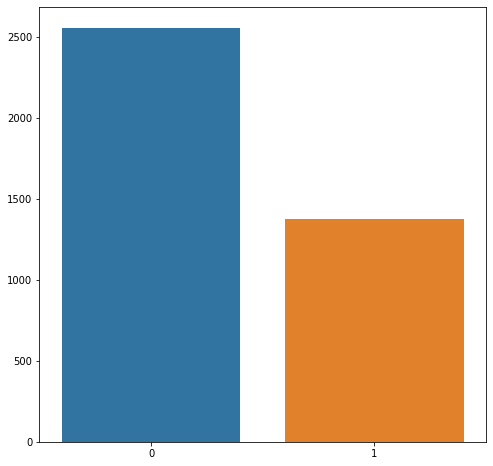

In [ ]:
# Plotting the class count

plt.figure(figsize=(8,8))
sns.barplot(x = list(class_count.keys()),y=list(class_count.values()))

### Key takeaways from data
<ul>
    <li>The <code>image_path</code> column contains path to the actual Brain MRI </li>
    <li> The <code>mask_path</code> column contains path to the mask ( segmentation done to localize brain tumor ) corresponding to the MRI </li>
    <li>The <code> mask</code> column contains whether or not the person has tumor </li>
    <li> Dataset is unbalanced class label 0 is approximately twice the frequency of class number 1</li>
</ul>

## Visualisation

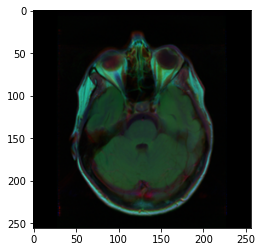

In [ ]:
# random brain MRI image
plt.imshow(cv2.imread(df.image_path[777]))

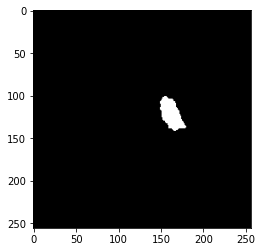

In [ ]:
# mask associated with it
plt.imshow(cv2.imread(df.mask_path[777]))

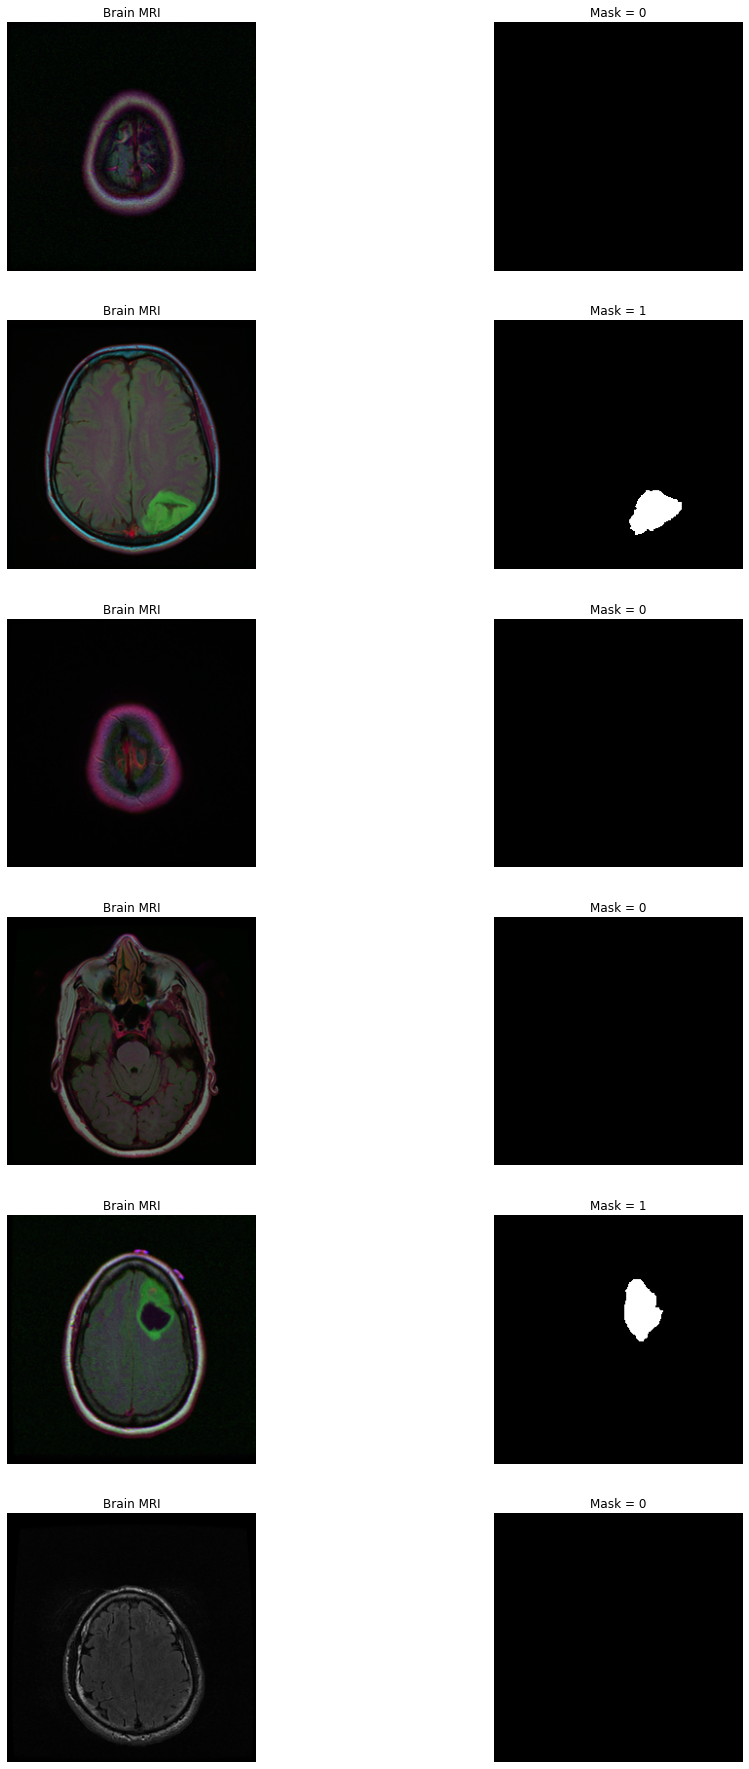

In [ ]:
# Visualising a random grid of MRI with mask

fig, axs = plt.subplots(6,2, figsize=(16,32))

for row in range(6):
    # generate a random number
    k = rnd.randint(0,len(df))

    # display the MRI
    axs[row][0].title.set_text("Brain MRI")
    axs[row][0].imshow(cv2.imread(df.image_path.iloc[k]))
    axs[row][0].axis('off')

    # display the mask
    axs[row][1].title.set_text(f"Mask = {df['mask'].iloc[k]}")
    axs[row][1].imshow(cv2.imread(df.mask_path.iloc[k]))
    axs[row][1].axis('off')

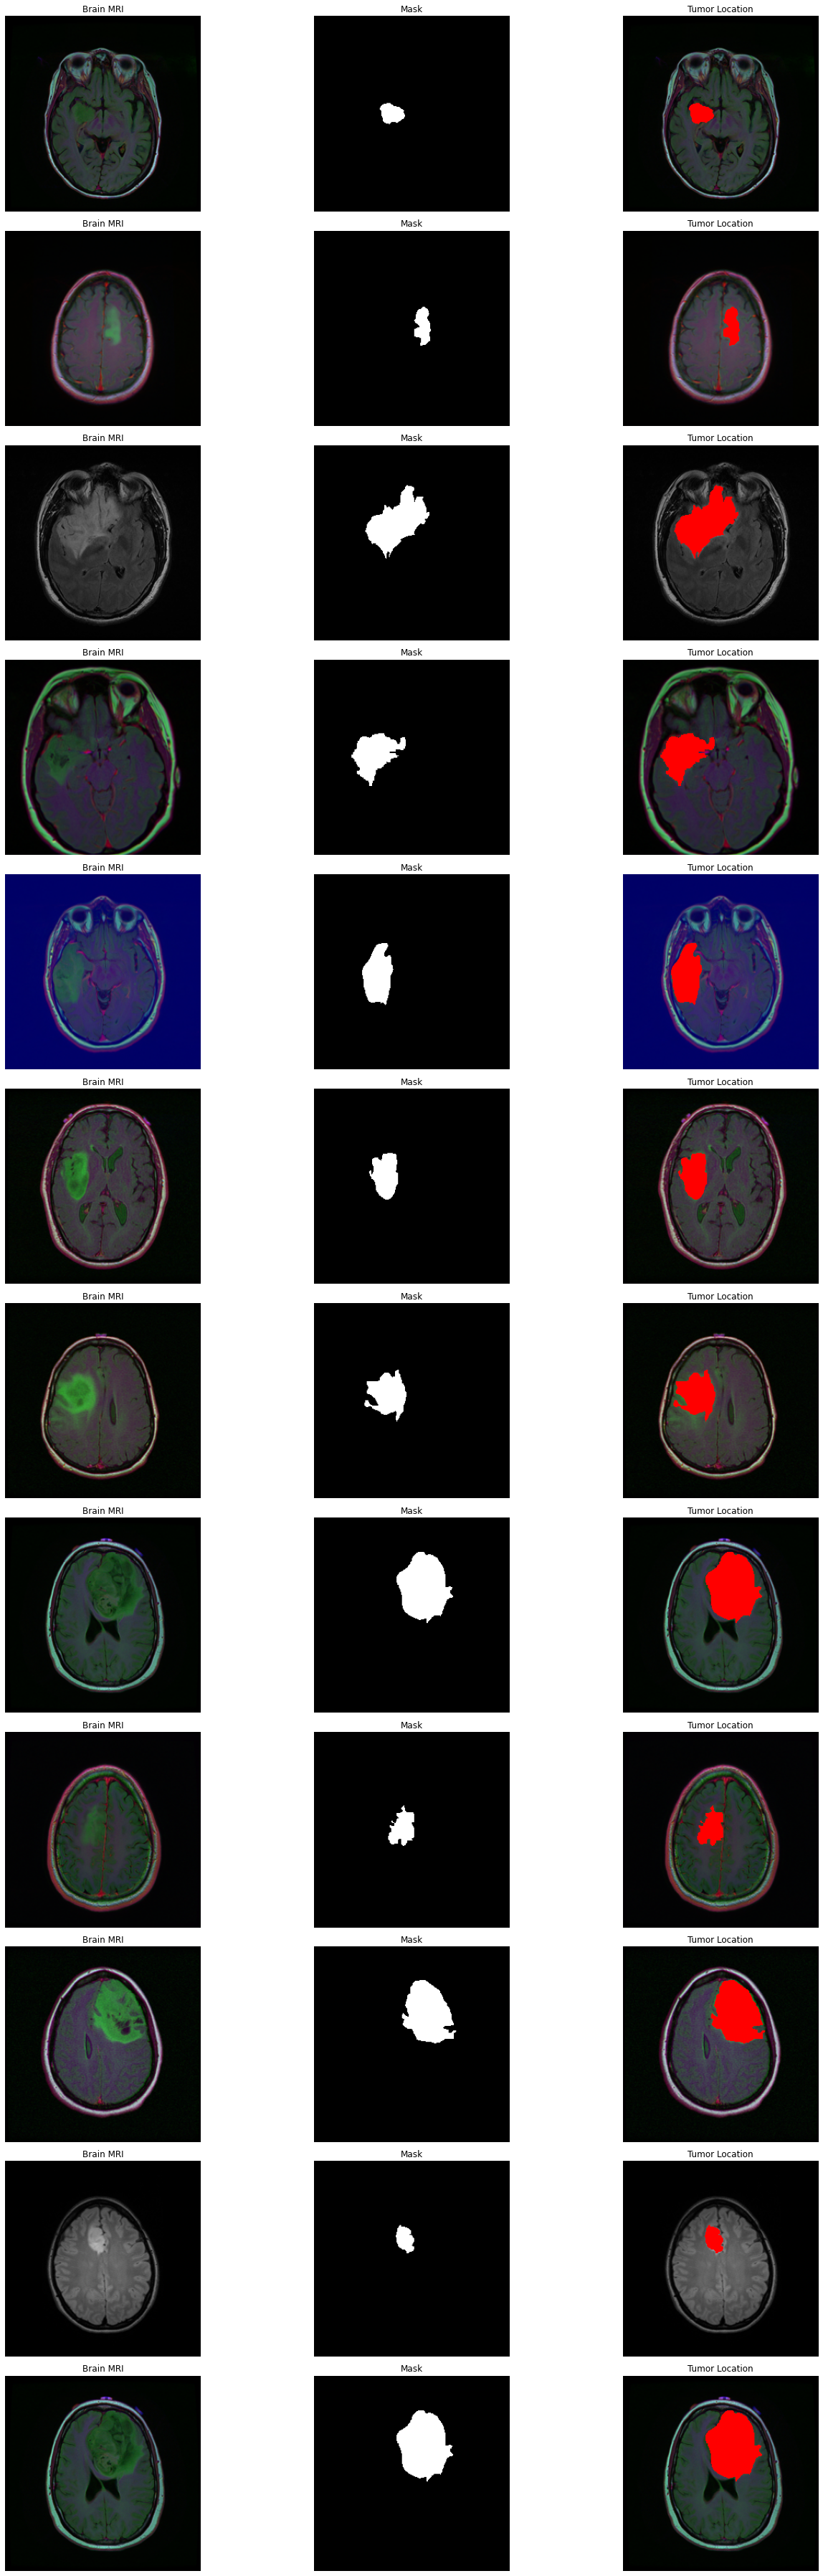

In [ ]:
# Visualising MRI, MASK and the tumor over the brain MRI for MRI with tumor

fig, axs = plt.subplots(12, 3, figsize = (20, 50))

tumor_df = df[df['mask']==1]

for row in range(12):
    # generate a random number
    k = rnd.randint(0,len(tumor_df))

    # display the MRI
    img = cv2.imread(tumor_df.image_path.iloc[k])
    axs[row][0].title.set_text("Brain MRI")
    axs[row][0].imshow(img)
    axs[row][0].axis('off')

    # display the mask
    mask = cv2.imread(tumor_df.mask_path.iloc[k])
    axs[row][1].title.set_text("Mask")
    axs[row][1].imshow(mask)
    axs[row][1].axis('off')

    # display the mask as red over the brain MRI
    # all the position in img where mask is 255 make it red
    img[mask.max(axis=-1) == [255]] = (255,0,0)
    axs[row][2].title.set_text("Tumor Location")
    axs[row][2].imshow(img)
    axs[row][2].axis('off')

fig.tight_layout()

# Training a Model to detect tumor

In [8]:
# drop the patient id column
df_train = df.drop(columns=['patient_id'],axis=1)
df_train.shape

(3929, 3)

In [9]:
# convert mask into string 
# this is important for using categorical mode in dataframe
df_train['mask'] = df_train['mask'].apply(lambda x:str(x))

In [10]:
# split into train and test
from sklearn.model_selection import train_test_split

train, test = train_test_split(df_train, test_size = 0.2)

In [ ]:
from keras_preprocessing.image import ImageDataGenerator


# creating an Image Datagenerator to scale the image and split it for validation
# we do not use augmentation here as we don't want our model to vary from the original distribution
# also the initial layers which are pre trained can take care of all the bariance
datagen = ImageDataGenerator(rescale=1.0/255., validation_split = 0.15)

In [ ]:
# train generator
train_generator=datagen.flow_from_dataframe(
    dataframe=train,
    directory= './',
    x_col='image_path',
    y_col='mask',
    subset="training",
    batch_size=16,
    shuffle=True,
    class_mode="categorical",
    target_size=(256,256)
)

# Validation Generator
valid_generator=datagen.flow_from_dataframe(
    dataframe=train,
    directory= './',
    x_col='image_path',
    y_col='mask',
    subset="validation",
    batch_size=16,
    shuffle=True,
    class_mode="categorical",
    target_size=(256,256)
)

Found 2672 validated image filenames belonging to 2 classes.
Found 471 validated image filenames belonging to 2 classes.


In [ ]:
# Get the ResNet50 base model
basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(256, 256, 3)))

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
# freezing the model weights

for layer in basemodel.layers:
  layers.trainable = False

In [ ]:
# making a head on top of the basemodel

X = basemodel.output
X = AveragePooling2D(pool_size = (4,4))(X)
X = Flatten(name= 'flatten')(X)
X = Dense(256, activation = "relu")(X)
X = Dropout(0.3)(X)#
X = Dense(256, activation = "relu")(X)
X = Dropout(0.3)(X)
X = Dense(2, activation = 'softmax')(X)

In [ ]:
# creating the model
model = Model(inputs = basemodel.input, outputs = X)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
# compile the model
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

In [ ]:
# use early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

# save the best model with least validation loss
checkpointer = ModelCheckpoint(filepath="../classifier-resnet-brain-weights.hdf5", verbose=1, save_best_only=True)

In [ ]:
# training the model
history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.n // 16, 
    epochs = 1,
    validation_data= valid_generator,
    validation_steps= valid_generator.n // 16,
    callbacks=[checkpointer, earlystopping]
)

In [ ]:
# save the model

model_json = model.to_json()
with open("../classifier-resnet-brain-mri.json","w") as json_file:
  json_file.write(model_json)

## Predictions

In [ ]:
# Load the model
with open('../classifier-resnet-brain-mri.json', 'r') as json_file:
    json_savedModel= json_file.read()
# load the model  
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights('../classifier-resnet-brain-weights.hdf5')
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

In [ ]:
# creating generator for test
test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
    dataframe=test,
    directory= './',
    x_col='image_path',
    y_col='mask',
    batch_size=16,
    shuffle=False,
    class_mode='categorical',
    target_size=(256,256)
)

Found 786 validated image filenames belonging to 2 classes.


In [ ]:
# prediction
predict = model.predict(test_generator, steps = test_generator.n // 16, verbose =1)
predict.shape

49/49 [==============================] - 201s 4s/step


(784, 2)

In [ ]:
# converting it to get class label
predict = np.argmax(predict,axis=-1)

In [ ]:
# converting the values inside predict to string
predict = np.array(list(map(lambda x:str(x),predict)))

In [ ]:
# since we have used test generator, it limited the images to len(predict), due to batch size
original = np.asarray(test['mask'])[:len(predict)]
len(original)

784

In [ ]:
# accuracy of the model
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(original, predict)
accuracy

0.9795918367346939

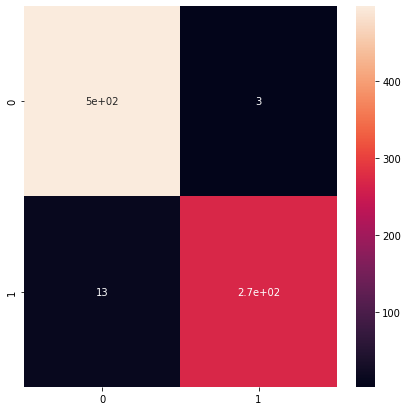

In [ ]:
# confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(original, predict)
plt.figure(figsize = (7,7))
sns.heatmap(cm, annot=True)

# Training a ResUNet model for localisation of tumor

In [ ]:
# take only those images which has tumor in it
tumor_df = df[df['mask']==1]

In [ ]:
tumor_df.head()

,patient_id,image_path,mask_path,mask
445,TCGA_DU_5872_19950223,TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_5.tif,TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_5_...,1
507,TCGA_DU_5874_19950510,TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_5.tif,TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_5_...,1
551,TCGA_DU_5854_19951104,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_6.tif,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_6_...,1
555,TCGA_DU_5854_19951104,TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_6.tif,TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_6_...,1
617,TCGA_DU_5853_19950823,TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_6.tif,TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_6_...,1


In [ ]:
tumor_df.shape

(1373, 4)

In [ ]:
# splitting the dataframe in two parts
from sklearn.model_selection import train_test_split

X_train, X_val = train_test_split(tumor_df, test_size=0.15)
X_test, X_val = train_test_split(X_val, test_size=0.5)

In [ ]:
# create separate list for imageId, classId to pass into the generator

train_ids = list(X_train.image_path)
train_mask = list(X_train.mask_path)

val_ids = list(X_val.image_path)
val_mask= list(X_val.mask_path)

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
  def __init__(self, ids , mask, image_dir = './', batch_size = 16, img_h = 256, img_w = 256, shuffle = True):

    self.ids = ids
    self.mask = mask
    self.image_dir = image_dir
    self.batch_size = batch_size
    self.img_h = img_h
    self.img_w = img_w
    self.shuffle = shuffle
    self.on_epoch_end()

  def __len__(self):
    'Get the number of batches per epoch'

    return int(np.floor(len(self.ids)) / self.batch_size)

  def __getitem__(self, index):
    'Generate a batch of data'

    #generate index of batch_size length
    indexes = self.indexes[index* self.batch_size : (index+1) * self.batch_size]

    #get the ImageId corresponding to the indexes created above based on batch size
    list_ids = [self.ids[i] for i in indexes]

    #get the MaskId corresponding to the indexes created above based on batch size
    list_mask = [self.mask[i] for i in indexes]


    #generate data for the X(features) and y(label)
    X, y = self.__data_generation(list_ids, list_mask)

    #returning the data
    return X, y

  def on_epoch_end(self):
    'Used for updating the indices after each epoch, once at the beginning as well as at the end of each epoch'
    
    #getting the array of indices based on the input dataframe
    self.indexes = np.arange(len(self.ids))

    #if shuffle is true, shuffle the indices
    if self.shuffle:
      np.random.shuffle(self.indexes)

  def __data_generation(self, list_ids, list_mask):
    'generate the data corresponding the indexes in a given batch of images'

    # create empty arrays of shape (batch_size,height,width,depth) 
    #Depth is 3 for input and depth is taken as 1 for output becasue mask consist only of 1 channel.
    X = np.empty((self.batch_size, self.img_h, self.img_w, 3))
    y = np.empty((self.batch_size, self.img_h, self.img_w, 1))

    #iterate through the dataframe rows, whose size is equal to the batch_size
    for i in range(len(list_ids)):
      #path of the image
      img_path = './' + str(list_ids[i])
      
      #mask path
      mask_path = './' + str(list_mask[i])
      
      #reading the original image and the corresponding mask image
      img = io.imread(img_path)
      mask = io.imread(mask_path)

      #resizing and coverting them to array of type float64
      img = cv2.resize(img,(self.img_h,self.img_w))
      img = np.array(img, dtype = np.float64)
      
      mask = cv2.resize(mask,(self.img_h,self.img_w))
      mask = np.array(mask, dtype = np.float64)

      #standardising 
      img -= img.mean()
      img /= img.std()
      
      mask -= mask.mean()
      mask /= mask.std()
      
      #Adding image to the empty array
      X[i,] = img
      
      #expanding the dimnesion of the image from (256,256) to (256,256,1)
      y[i,] = np.expand_dims(mask, axis = 2)
    
    #normalizing y
    y = (y > 0).astype(int)

    return X, y


In [ ]:
training_generator = DataGenerator(train_ids,train_mask)
validation_generator = DataGenerator(val_ids,val_mask)

## Model

<center><a href="https://ibb.co/7ycHkTK"><img src="https://i.ibb.co/ryPgdLH/Healthcare-Slide14.png" alt="Healthcare-Slide14" border="0" /></a></center>

In [ ]:
def res_block(X,filter):
    """
    Res block which will be used in ResUNet 
    Arguments:
        X : Input to the block
        filter : filter size for convolution
    Returns:
        X : output after performing the operations in these block
    """

    # make a copy of X
    X_copy = X

    # main path
    # we use he initialisation since we are using relu
    X = Conv2D(filter, kernel_size = (1,1) ,strides = (1,1),kernel_initializer ='he_normal')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X) 

    X = Conv2D(filter, kernel_size = (3,3), strides =(1,1), padding = 'same', kernel_initializer ='he_normal')(X)
    X = BatchNormalization()(X)

    # Shortcut path
    X_copy = Conv2D(filter, kernel_size = (1,1), strides =(1,1), kernel_initializer ='he_normal')(X_copy)
    X_copy = BatchNormalization()(X_copy)

    # Add them
    X = Add()([X,X_copy])

    # Apply relu activation and return
    X = Activation('relu')(X)

    return X

In [ ]:
def upscale(X,skip):
    """
    Function used to Upsample the image from bottleneck
    Arguments:
        X : input from the previous expansion layer
        skip : skip connection (input from contraction layer)
    Returns:
        X : Tensor after performing all the operation
    """
    X = UpSampling2D((2,2))(X)
    merge = Concatenate()([X,skip])

    return merge

In [ ]:
# model

# input tensor
input_ = Input(shape=(256,256,3))

# initial stage
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(input_)
conv1_in = BatchNormalization()(conv1_in)
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(conv1_in)
conv1_in = BatchNormalization()(conv1_in)
pool_1 = MaxPool2D(pool_size = (2,2))(conv1_in)

# contraction 1
conv2_in = res_block(pool_1, 32)
pool_2 = MaxPool2D(pool_size = (2,2))(conv2_in)

# contraction 2
conv3_in = res_block(pool_2, 64)
pool_3 = MaxPool2D(pool_size = (2,2))(conv3_in)

# contraction 3
conv4_in = res_block(pool_3, 128)
pool_4 = MaxPool2D(pool_size = (2,2))(conv4_in)

# bottleneck
conv5_in = res_block(pool_4, 256)

# Expansion 1
up_1 = upscale(conv5_in, conv4_in)
up_1 = res_block(up_1, 128)

# Expansion 2
up_2 = upscale(up_1, conv3_in)
up_2 = res_block(up_2, 64)

# Expansion 3
up_3 = upscale(up_2, conv2_in)
up_3 = res_block(up_3, 32)

# Expansion 4
up_4 = upscale(up_3, conv1_in)
up_4 = res_block(up_4, 16)

# Final Output
output = Conv2D(1, (1,1), padding = "same", activation = "sigmoid")(up_4)

In [ ]:
res_u_net_model = Model(inputs=input_,outputs=output)
res_u_net_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [11]:
# loss functions
def tversky(y_true, y_pred,alpha=0.7, smooth = 1e-6):
    """
    tversky index
    Arguments:
        y_true : Actual y value
        y_pred : Predicted y value
        alpha : alpha value used for weighting false negative
        smooth : ensuring denominator is not 0
    """
    # flattening 
    y_true_flat = K.flatten(y_true)
    y_pred_flat = K.flatten(y_pred)

    # finding true_poritive(TP),false_negative(FN),false_positive(FP)
    TP = K.sum(y_true_flat*y_pred_flat)
    FN = K.sum(y_true_flat*(1-y_pred_flat))
    FP = K.sum((1-y_true_flat)*y_pred_flat)

    return (TP+smooth)/(TP + alpha*FN + (1-alpha)*FP + smooth)

def tversky_loss(y_true, y_pred):
    """
    tversky loss
    Arguments:
        y_true : Actual y value
        y_pred : Predicted y value
    """
    return 1 - tversky(y_true, y_pred)

def focal_tversky(y_true,y_pred,gamma=0.75):
    """
    focal tversky
    Arguments:
        y_true : Actual y value
        y_pred : Predicted y value
        gamma : power 
    """
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    tv = tversky(y_true, y_pred)
    return K.pow((1-tv), gamma)


In [ ]:
# Compile the model
adam = tf.keras.optimizers.Adam(learning_rate = 0.05, epsilon = 0.1)
res_u_net_model.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

In [ ]:
# use early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="../ResUNet-weights.hdf5", verbose=1, save_best_only=True)

In [ ]:
# start the training
history = res_u_net_model.fit(
    training_generator,
    epochs = 20, 
    validation_data = validation_generator, 
    callbacks = [checkpointer, earlystopping]
)

Epoch 1/20
72/72 [==============================] - ETA: 0s - loss: 0.8651 - tversky: 0.1748 
Epoch 1: val_loss improved from inf to 0.79516, saving model to ../ResUNet-weights.hdf5
72/72 [==============================] - 1339s 18s/step - loss: 0.8651 - tversky: 0.1748 - val_loss: 0.7952 - val_tversky: 0.2630
Epoch 2/20
72/72 [==============================] - ETA: 0s - loss: 0.5495 - tversky: 0.5453
Epoch 2: val_loss improved from 0.79516 to 0.51543, saving model to ../ResUNet-weights.hdf5
72/72 [==============================] - 50s 692ms/step - loss: 0.5495 - tversky: 0.5453 - val_loss: 0.5154 - val_tversky: 0.5862
Epoch 3/20
72/72 [==============================] - ETA: 0s - loss: 0.4076 - tversky: 0.6959
Epoch 3: val_loss improved from 0.51543 to 0.48381, saving model to ../ResUNet-weights.hdf5
72/72 [==============================] - 30s 416ms/step - loss: 0.4076 - tversky: 0.6959 - val_loss: 0.4838 - val_tversky: 0.6165
Epoch 4/20
72/72 [==============================] - ETA: 0

In [ ]:
model_json = res_u_net_model.to_json()
with open("../ResUNet-model.json","w") as json_file:
  json_file.write(model_json)

# Prediction

In [16]:
def predict(test, model, model_seg):
    '''
    This function is used to make prediction 
    Arguments:
        test : the test dataframe
        model : model to detect if tumor exist or not
        model_seg : Model to localise and detect tumor
    Returns:
        image_id : path of the image
        has_mask : If the image has tumor or not
        mask : mask associated with the image    
    '''

    #directory
    directory = "./"

    #Creating empty list to store the results
    mask = []
    image_id = []
    has_mask = []

    #iterating through each image in the test data
    for i in test.image_path:

        path = directory + str(i)

        #reading the image
        img = io.imread(path)

        #Normalizing the image
        img = img * 1./255.

        #Reshaping the image
        img = cv2.resize(img,(256,256))

        #Converting the image into array
        img = np.array(img, dtype = np.float64)
        
        #reshaping the image from 256,256,3 to 1,256,256,3
        img = np.reshape(img, (1,256,256,3))

        #making prediction on the image
        is_defect = model.predict(img)

        #if tumour is not present we append the details of the image to the list
        if np.argmax(is_defect) == 0:
            image_id.append(i)
            has_mask.append(0)
            mask.append(np.zeros((1,256,256,3)))
            continue

        #Read the image
        img = io.imread(path)

        #Creating a empty array of shape 1,256,256,1
        X = np.empty((1, 256, 256, 3))

        #resizing the image and coverting them to array of type float64
        img = cv2.resize(img,(256,256))
        img = np.array(img, dtype = np.float64)

        #standardising the image
        img -= img.mean()
        img /= img.std()

        #converting the shape of image from 256,256,3 to 1,256,256,3
        X[0,] = img

        #make prediction
        predict = model_seg.predict(X)

        #if the sum of predicted values is equal to 0 then there is no tumour
        if predict.round().astype(int).sum() == 0:
            image_id.append(i)
            has_mask.append(0)
            mask.append(np.zeros((1,256,256,3)))
        else:
        #if the sum of pixel values are more than 0, then there is tumour
            image_id.append(i)
            has_mask.append(1)
            mask.append(predict)


    return image_id, mask, has_mask

In [14]:
# load saved models
# Load the classification model
with open('../classifier-resnet-brain-mri.json', 'r') as json_file:
    json_savedModel= json_file.read()
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights('../classifier-resnet-brain-weights.hdf5')
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

# Load the segmentation model
with open ('../ResUNet-model.json', 'r') as json_file:
    json_savedModel= json_file.read()
model_seg = tf.keras.models.model_from_json(json_savedModel)
model_seg.load_weights('../ResUNet-weights.hdf5')
adam = tf.keras.optimizers.Adam(learning_rate = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

In [17]:
# making the prediction
image_id, mask, has_mask = predict(test, model, model_seg)

In [18]:
predicted_df = pd.DataFrame({'image_path': image_id,'predicted_mask': mask,'has_mask': has_mask})
predicted_df.head()

,image_path,predicted_mask,has_mask
0,TCGA_EZ_7264_20010816/TCGA_EZ_7264_20010816_5.tif,"[[[[0. 0. 0.], [0. 0. 0.], [0. 0. 0.], [0. 0. ...",0
1,TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_19970709_10...,"[[[[0. 0. 0.], [0. 0. 0.], [0. 0. 0.], [0. 0. ...",0
2,TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_19...,"[[[[8.696277e-06], [7.484915e-06], [9.163689e-...",1
3,TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_6.tif,"[[[[1.02681415e-05], [1.21614585e-05], [1.0487...",1
4,TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_6.tif,"[[[[0. 0. 0.], [0. 0. 0.], [0. 0. 0.], [0. 0. ...",0


In [19]:
# Merge both the dataframes
predicted_df = test.merge(predicted_df, on = 'image_path')
predicted_df.head()

,image_path,mask_path,mask,predicted_mask,has_mask
0,TCGA_EZ_7264_20010816/TCGA_EZ_7264_20010816_5.tif,TCGA_EZ_7264_20010816/TCGA_EZ_7264_20010816_5_...,0,"[[[[0. 0. 0.], [0. 0. 0.], [0. 0. 0.], [0. 0. ...",0
1,TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_19970709_10...,TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_19970709_10...,0,"[[[[0. 0. 0.], [0. 0. 0.], [0. 0. 0.], [0. 0. ...",0
2,TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_19...,TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_19...,1,"[[[[8.696277e-06], [7.484915e-06], [9.163689e-...",1
3,TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_6.tif,TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_6_...,0,"[[[[1.02681415e-05], [1.21614585e-05], [1.0487...",1
4,TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_6.tif,TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_6_...,0,"[[[[0. 0. 0.], [0. 0. 0.], [0. 0. 0.], [0. 0. ...",0


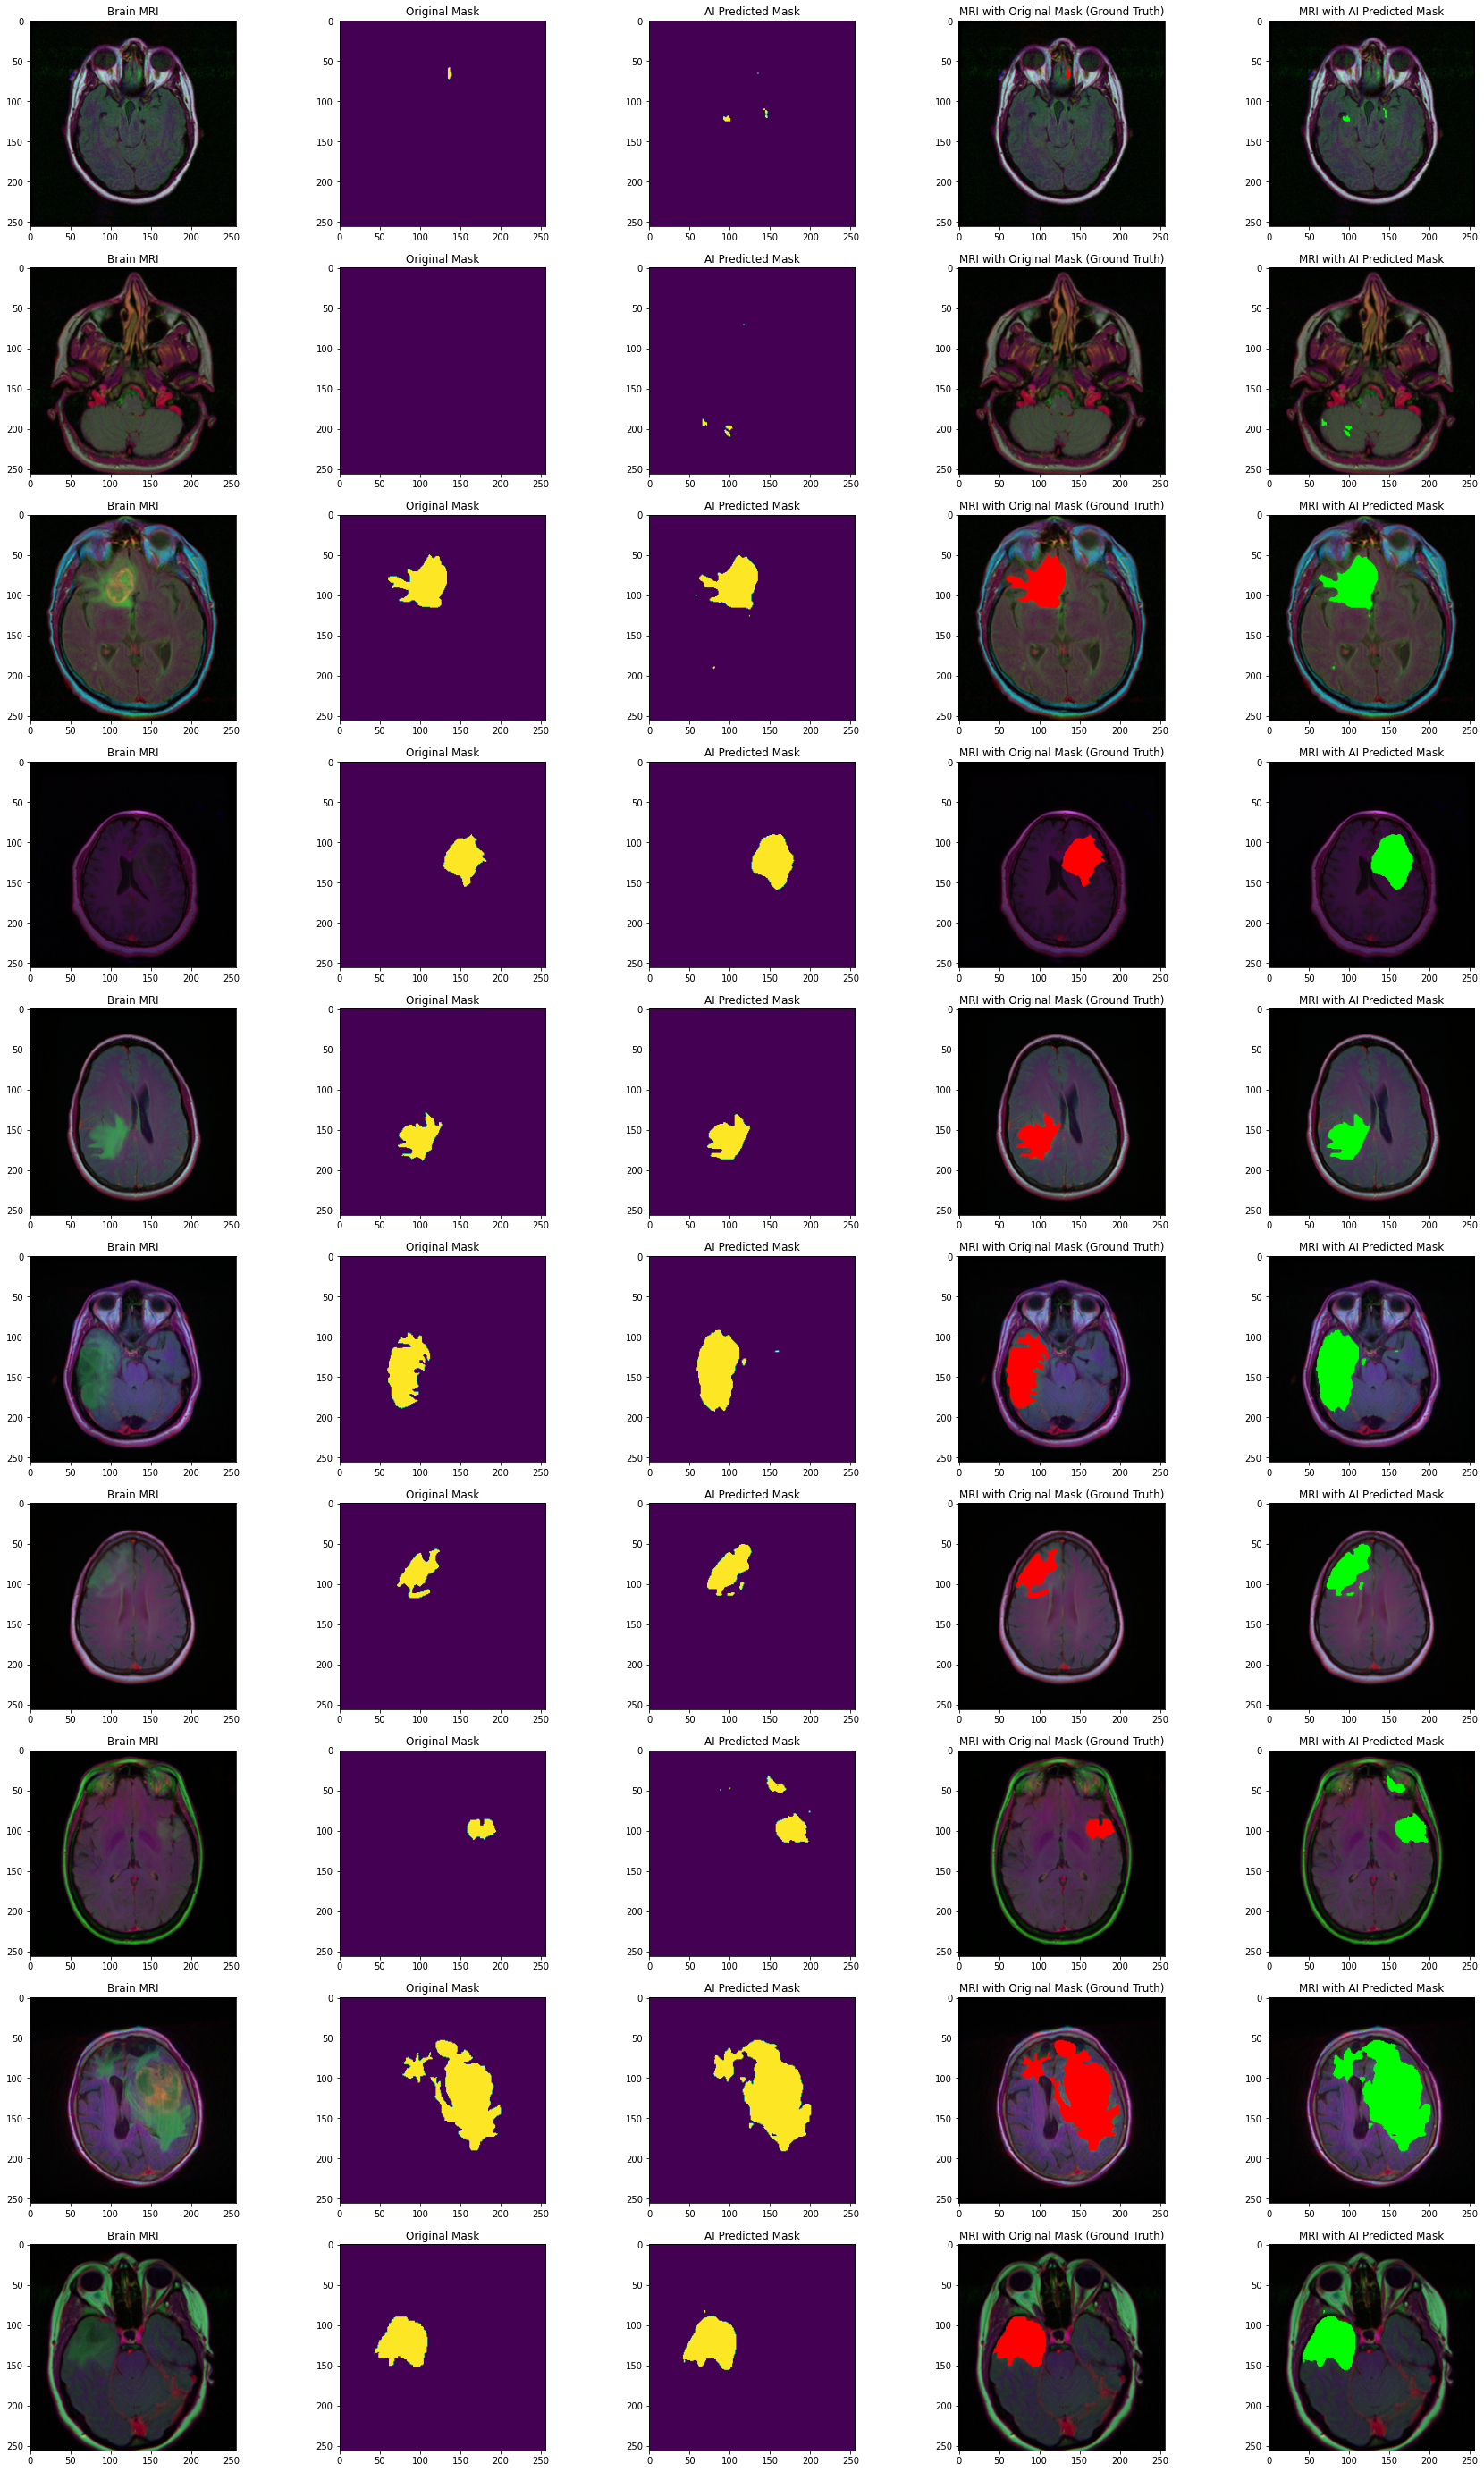

In [21]:
# plotting masks

# taking only those values where mask was predicted to be true
predicted_mask_df = predicted_df[predicted_df['has_mask']==1]

fig, axs = plt.subplots(10, 5, figsize=(30, 50))

for row in range(10):
    # read the images and convert them to RGB format
    img = io.imread(predicted_mask_df.image_path.iloc[row])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[row][0].title.set_text("Brain MRI")
    axs[row][0].imshow(img)

    # Obtain the mask for the image 
    mask = io.imread(predicted_mask_df.mask_path.iloc[row])
    axs[row][1].title.set_text("Original Mask")
    axs[row][1].imshow(mask)

    # Obtain the predicted mask for the image 
    predicted_mask = np.asarray(predicted_mask_df.predicted_mask.iloc[row])[0].squeeze().round()
    axs[row][2].title.set_text("AI Predicted Mask")
    axs[row][2].imshow(predicted_mask)
    
    # Apply the mask to the image 'mask==255'
    img[mask == 255] = (255, 0, 0)
    axs[row][3].title.set_text("MRI with Original Mask (Ground Truth)")
    axs[row][3].imshow(img)

    img_ = io.imread(predicted_mask_df.image_path.iloc[row])
    img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
    img_[predicted_mask == 1] = (0, 255, 0)
    axs[row][4].title.set_text("MRI with AI Predicted Mask")
    axs[row][4].imshow(img_)